This notebook is to visualize the two filters of grid search algo to check whether they are functioning correctly

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
import pandas as pd
import numpy as np
from config import CONFIG
from prototype_utils import filter_roi, bboxes_df_to_numpy_corners, plot_point_cloud_and_bboxes

In [3]:
home = os.path.join(os.path.expanduser('~'), "buni")

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 0
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)


points = Sweep.from_feather(frame_path).xyz
points_roi = filter_roi(points)[:,:2]

In [4]:
def apply_rect_filter(df, aspect_ratio_col, area_col, max_ratio, max_area):
    """
    Filters bounding boxes based on aspect ratio and area thresholds.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box information.
        aspect_ratio_col (str): Column name for aspect ratios in the DataFrame.
        area_col (str): Column name for areas in the DataFrame.
        max_ratio (float): Minimum aspect ratio for filtering bounding boxes.
        max_area (float): Minimum area for filtering bounding boxes.

    Returns:
        tuple: (narrow_boxes, other_boxes)
            - narrow_boxes (pd.DataFrame): Subset of the DataFrame containing bounding boxes classified as narrow.
            - other_boxes (pd.DataFrame): Subset of the DataFrame containing all other bounding boxes.
    """
    # Create a single mask for narrow rectangles
    narrow_mask = (df[aspect_ratio_col] < max_ratio) & (df[area_col] < max_area)

    # Apply the mask to separate narrow and other rectangles
    narrow_boxes = df[narrow_mask]
    other_boxes = df[~narrow_mask]  # Complement of the narrow mask

    # Reset the indices for both DataFrames
    narrow_boxes.reset_index(drop=True, inplace=True)
    other_boxes.reset_index(drop=True, inplace=True)

    return narrow_boxes, other_boxes

def apply_large_sq_filter(df, aspect_ratio_col, area_col, min_ratio, min_area):
    """
    Filters bounding boxes to identify large squares based on a single condition.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box information.
        aspect_ratio_col (str): Column name for aspect ratios in the DataFrame.
        area_col (str): Column name for areas in the DataFrame.
        min_ratio (float): Minimum aspect ratio tolerance (ε).
        min_area (float): Minimum area for large squares (T_LargeArea).

    Returns:
        tuple: (large_squares, rest_boxes)
            - large_squares (pd.DataFrame): Subset of the DataFrame containing bounding boxes classified as large squares.
            - rest_boxes (pd.DataFrame): Subset of the DataFrame containing all other bounding boxes.
    """
    # Create a single mask for large squares
    large_square_mask = (df[aspect_ratio_col] >= min_ratio) & (df[aspect_ratio_col] <= 1.0) & (df[area_col] > min_area)

    # Apply the mask to separate large squares and other rectangles
    large_squares = df[large_square_mask]
    rest_boxes = df[~large_square_mask]  # Complement of the large square mask

    # Reset the indices for both DataFrames
    large_squares.reset_index(drop=True, inplace=True)
    rest_boxes.reset_index(drop=True, inplace=True)

    return large_squares, rest_boxes





In [5]:
if CONFIG['ROI']:
    ps_base_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['ROI'])
else:
    ps_base_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['FULL_RANGE'])

In [6]:
ps_scene_path = os.path.join(ps_base_path, scene_id)
ps_frame_path = os.path.join(ps_scene_path, f"{frame_id}.feather")
ps_df = pd.read_feather(ps_frame_path)
ps_corners = bboxes_df_to_numpy_corners(ps_df)


A plot of unfiltered bounding boxes

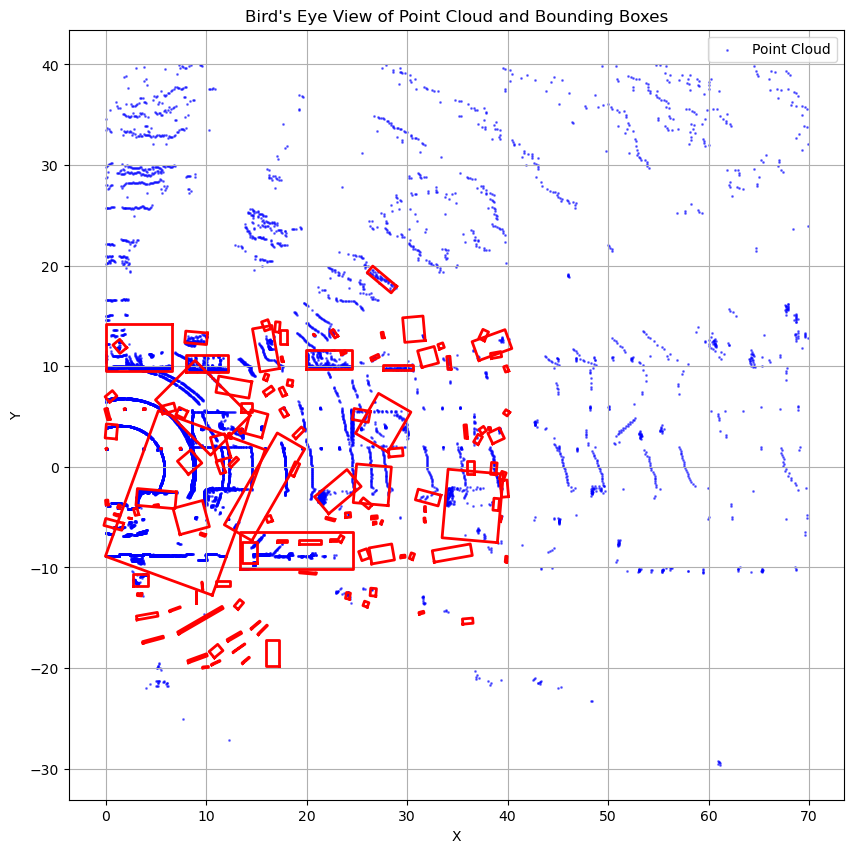

In [7]:
plot_point_cloud_and_bboxes(points_roi, ps_corners)

In [8]:
ps_df['aspect_ratio'] = ps_df['box_width'] / ps_df['box_length']
ps_df['area'] = ps_df['box_width'] * ps_df['box_length']

In [9]:
ps_df.shape

(130, 7)

In [10]:
narrow_boxes, other_boxes = apply_rect_filter(ps_df, 'aspect_ratio', 'area', 0.35, 4)

Narrow Rect Filter => First plot is all narrow boxes and the second one contains all other boxes

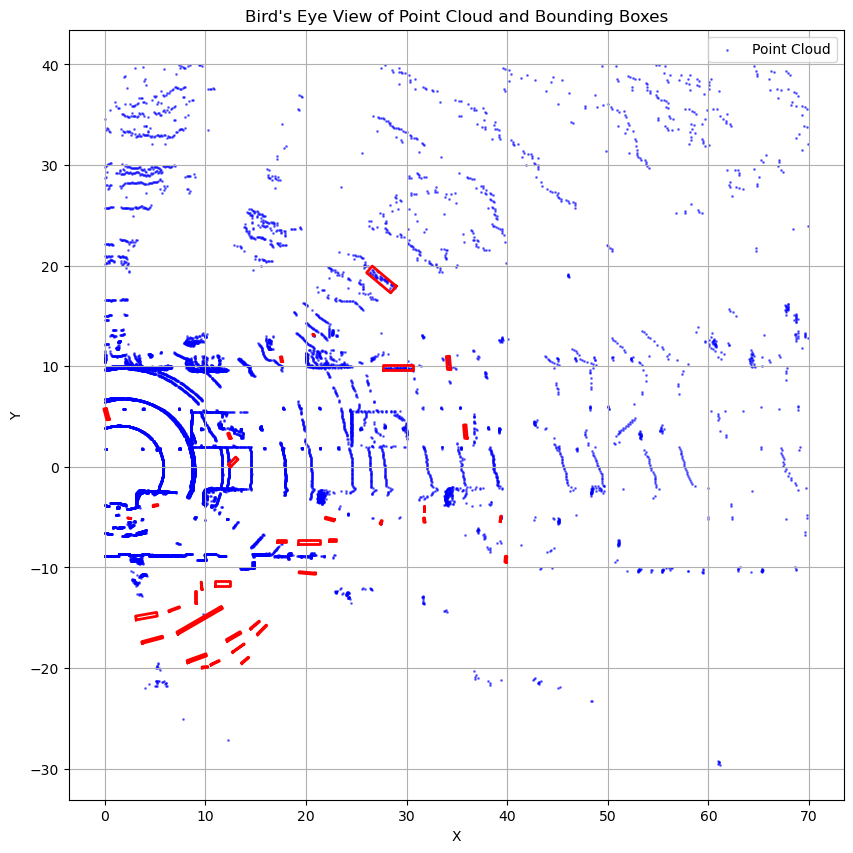

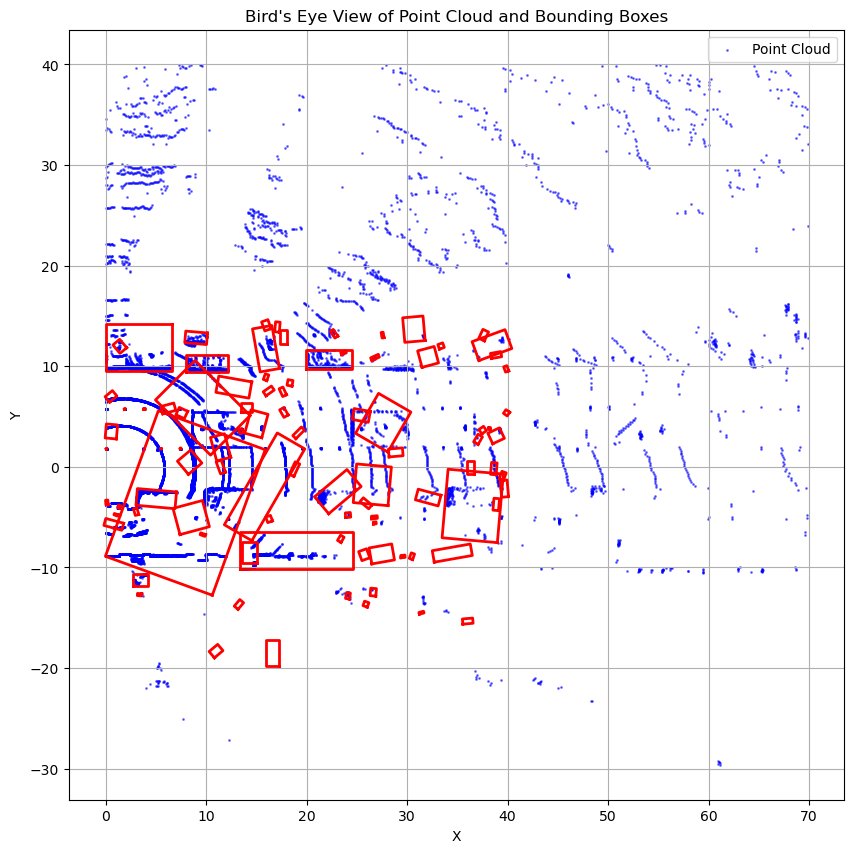

In [11]:
plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(narrow_boxes))
plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(other_boxes))

In [12]:
large_squares, rest_boxes = apply_large_sq_filter(ps_df, 'aspect_ratio', 'area', 0.5, 20)

Square Filter => First plot is all large squares and the second one is the rest 

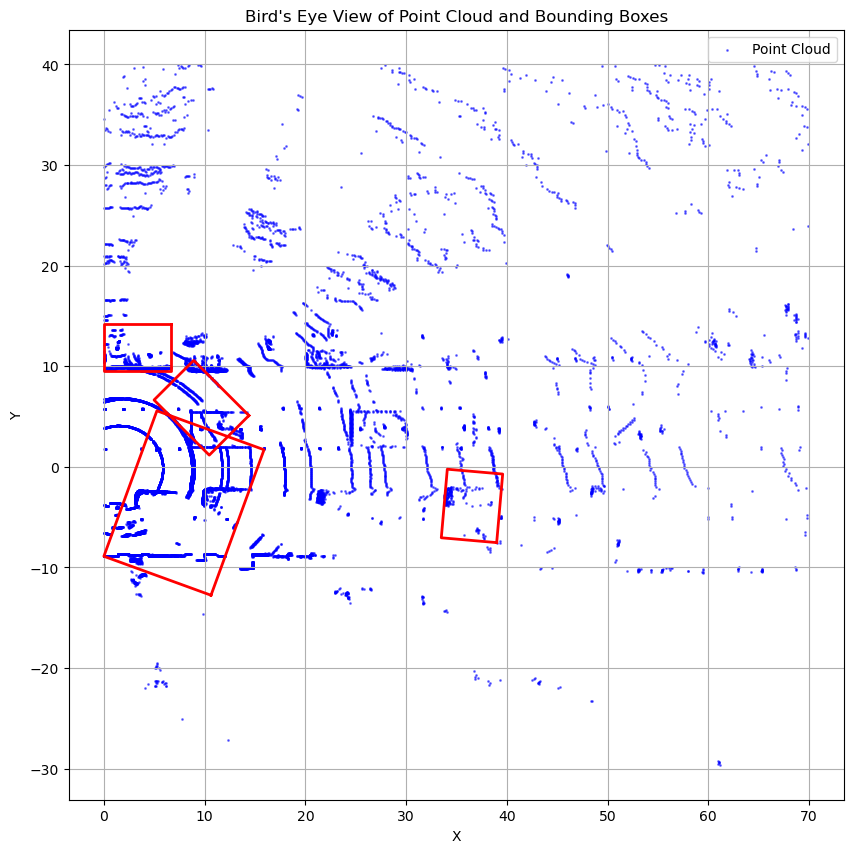

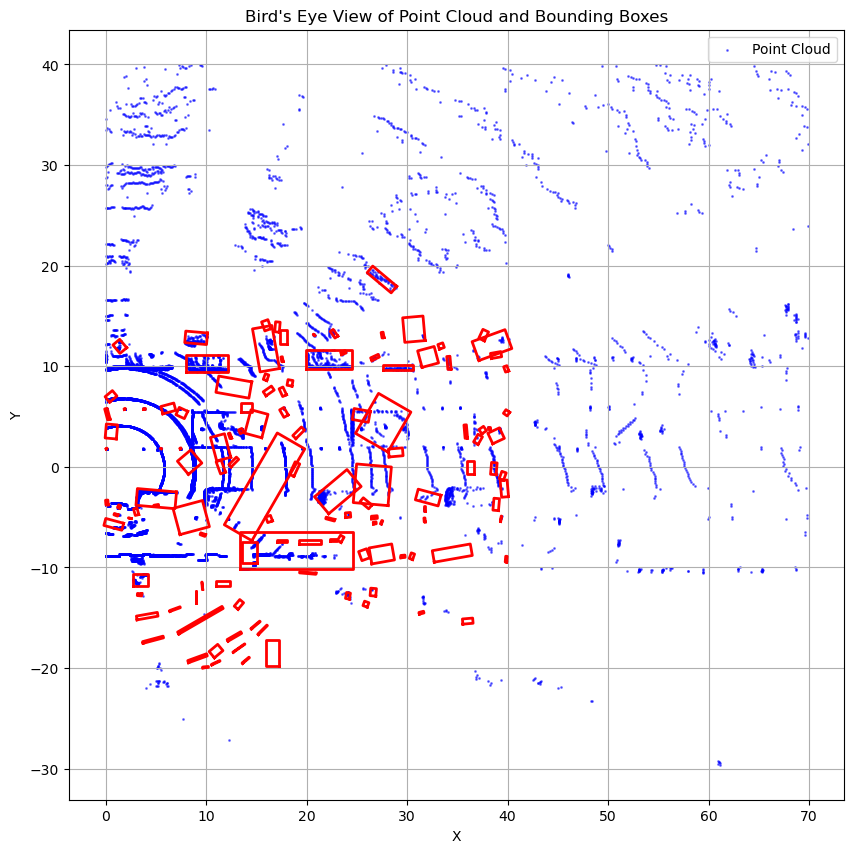

In [13]:
plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(large_squares))
plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(rest_boxes))

Both Filters together => First plot is unfiltered and the second one is both filteres combined

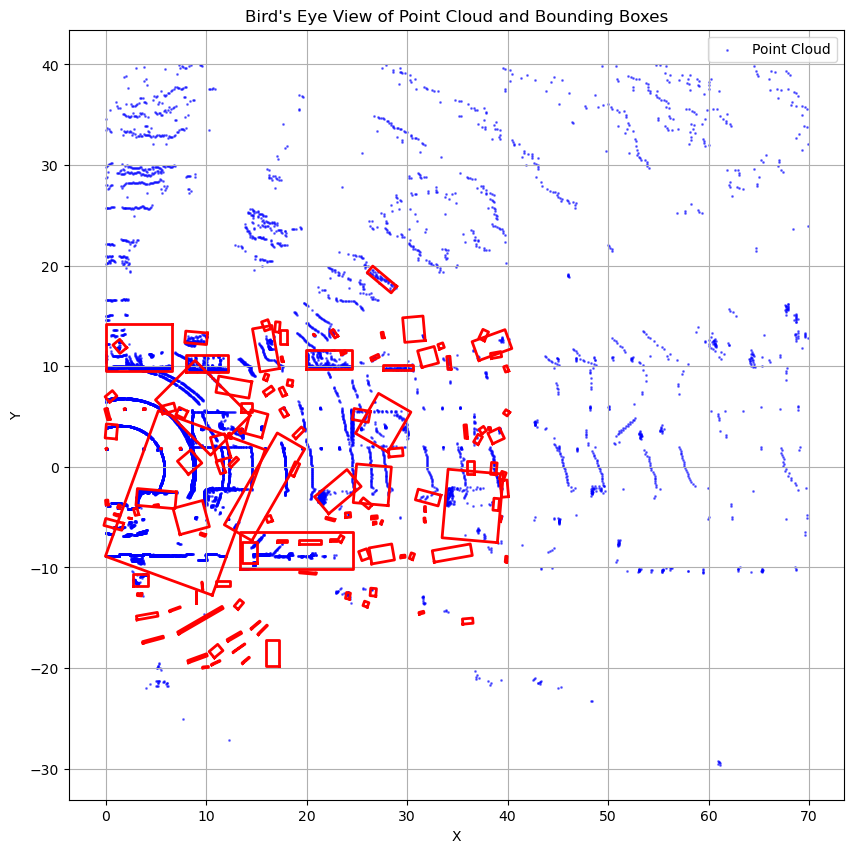

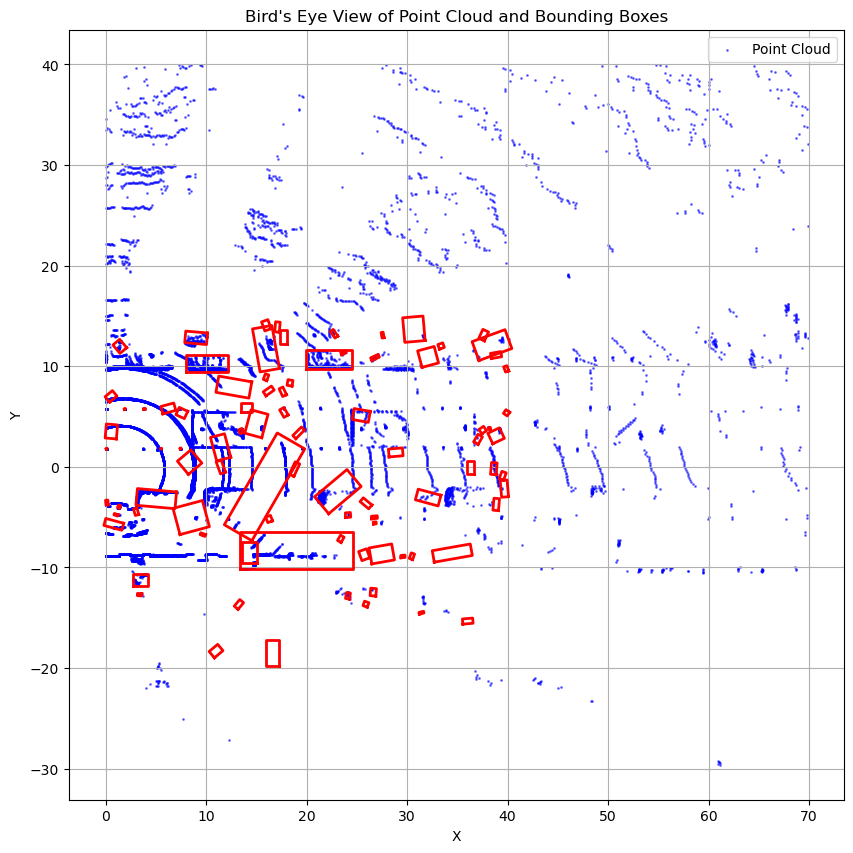

In [18]:
_ , final_boxes= apply_large_sq_filter(other_boxes, 'aspect_ratio', 'area', 0.5, 10)

plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(ps_df))
plot_point_cloud_and_bboxes(points_roi, bboxes_df_to_numpy_corners(final_boxes))